In [1]:
import time
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.animation as animation

from scipy import linalg
from scipy import sparse
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, StatevectorSimulator, UnitarySimulator
from qiskit_aer.primitives import Sampler, Estimator
from qiskit.quantum_info import SparsePauliOp
from tqdm.auto import tqdm

from lib import (LinearCombinationHamiltonianSimulation, 
                WaveEquationEvolution, 
                LaplacianOperator2d,
                OperatorList, 
                DifferentialOperator, 
                ShiftOperator,
                IdentityOperator,
                custom_structure2d)

In [2]:
# Property for figures
plt.rcParams['font.family'] = "Liberation Serif"
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['font.size'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 3.0

In [3]:
custom = 'custom1'
structure = custom_structure2d('{}.txt'.format(custom), add_identity=1)

In [4]:
def wave_equation_evolution_with_object(n, v, structure):
    
    op = WaveEquationEvolution(n, dim=2, diff_type='forward', periodic='y', compact=False)
    factor = (v - 1.0)
    for key in structure.keys():
        op_list_added = []
        coeffs_added = []
        # add identity to the most significant bit (ancilla bit)
        rho = 'I'*2 + key

        for term, coeff in zip(op._op_list, op._coeffs):
            if term[0] == 'p':    
                c = []
                skip = False
                for a, b in zip(term, rho):
                    # a x b
                    if a == 'I':
                        c.append(b)
                    elif b == 'I':
                        c.append(a)
                    elif a == 'm' and b == 'o':
                        c.append(a)
                    elif a == 'p' and b == 'z':
                        c.append(a)
                    elif a == 'z' and b == 'z':
                        c.append(a)
                    elif a == 'o' and b == 'o':
                        c.append(a)
                    else:
                        skip = True
    
                if not skip:
                    op_list_added.append(''.join(c))
                    coeffs_added.append(factor * coeff)
                
            elif term[0] == 'm':
                c = []
                skip = False
                for a, b in zip(term, rho):
                    # b x a
                    if a == 'I':
                        c.append(b)
                    elif b == 'I':
                        c.append(a)
                    elif b == 'z' and a == 'm':
                        c.append(a)
                    elif b == 'o' and a == 'p':
                        c.append(a)
                    elif b == 'z' and a == 'z':
                        c.append(a)
                    elif b == 'o' and a == 'o':
                        c.append(a)
                    else:
                        skip = True
    
                if not skip:
                    op_list_added.append(''.join(c))
                    coeffs_added.append(factor * coeff)
        
        op._op_list += op_list_added
        op._coeffs += coeffs_added

    return op

In [5]:
backend = UnitarySimulator()

# Parameters
T = 20.0
nx = 5
ny = 5
v = 10

# Classical setting
dt_cl = 0.001
op = LaplacianOperator2d(num_qubits_x=nx, num_qubits_y=ny, periodic='y', neumann='right')
n = op.num_qubits + 1
K = op.to_matrix(sparse=False)
st = OperatorList(list(structure.keys()), list(structure.values()))
chi = st.to_matrix(sparse=False).real
K = ((v**2 - 1.0) * chi + np.eye(2**(n-1))) @ K
KK = np.zeros((2**n, 2**n), dtype=np.complex128)
KK[:2**(n-1), 2**(n-1):] = K
KK[2**(n-1):, :2**(n-1)] = np.eye(2**(n-1))
KK[2**(n-1):, 2**(n-1):] = dt_cl * K

# Classical time evolution (FDM)
u = np.zeros((2, 2**ny, 2**nx))
u[0, 2**(ny-1)-2:2**(ny-1)+2, 2**(nx-1)-2:2**(nx-1)] = 1
u = u.flatten()
sc = 1 / np.sqrt(np.sum(u))
u = u / np.sqrt(np.sum(u))
u_list = [u]
for D in tqdm(range(int(T/dt_cl))): 
    u = u + dt_cl * np.dot(KK, u)
    u_list.append(u)
u_list = np.array(u_list)

del K, KK

# Quantum setting
dt = 0.01
dt_sim = 0.001
op = wave_equation_evolution_with_object(nx, v, structure)
n = op.num_qubits
H = op.to_matrix(sparse=False)
U = linalg.expm(-1j*H*dt_sim)
psi_c = np.zeros((2, 2, 2**nx, 2**ny), dtype=np.complex128)
psi_c[0, 0, 2**(ny-1)-2:2**(ny-1)+2, 2**(nx-1)-2:2**(nx-1)] = 1
psi_c = psi_c.flatten()
psi_c = psi_c / np.sqrt(np.sum(psi_c))

# Quantum time evolution (LCHS)
sim = LinearCombinationHamiltonianSimulation(op, num_qubits_lcu=0, lsb_pos=0)
circ = sim.get_evolve_circ(dt_sim, barrier=False, measure=False)
circ = transpile(circ, backend=backend, optimization_level=2, seed_transpiler=42)
n = sim._num_qubits
qc = QuantumCircuit(n)
U_circ = backend.run(circ).result().get_unitary().data
U_circ = np.exp(-1j*np.angle(U_circ[0, 0])) * U_circ # global phase
psi_q = psi_c.copy()

psi_c_list = []
psi_q_list = []
for D in tqdm(range(int(T/dt_sim))):

    if D % int(dt / dt_sim) == 0:
        psi_c_list.append(psi_c)
        psi_q_list.append(psi_q)
    
    psi_c = np.dot(U, psi_c)
    psi_q = np.dot(U_circ, psi_q)

psi_c_list.append(psi_c)
psi_q_list.append(psi_q)

psi_c_list = np.array(psi_c_list)
psi_q_list = np.array(psi_q_list)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

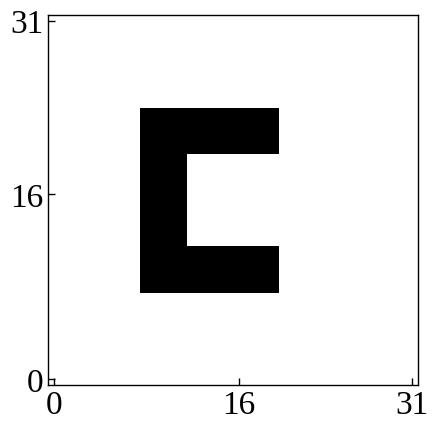

In [6]:
# Structure (spatially varying parameters)
x, y = np.meshgrid(np.arange(2**ny), np.arange(2**nx))
z = np.diag(chi * (v - 1.0) + 1.0).reshape((2**ny, 2**nx)) 
fig, ax = plt.subplots(1, 1)
ax.imshow(z, cmap='gray_r', origin='lower')
ax.set_aspect('equal')
ax.set_xticks(list(range(0, 2**nx, 16)) + [2**nx - 1])
ax.set_yticks(list(range(0, 2**ny, 16)) + [2**ny - 1])

0.08333074893162011 0.08343712924239251 0.08344141286608925
0.11620781123205591 0.1158675841709559 0.11582240632986757
0.35355339059327373 0.35355339059327373 0.35355339059327373


<Figure size 640x480 with 0 Axes>

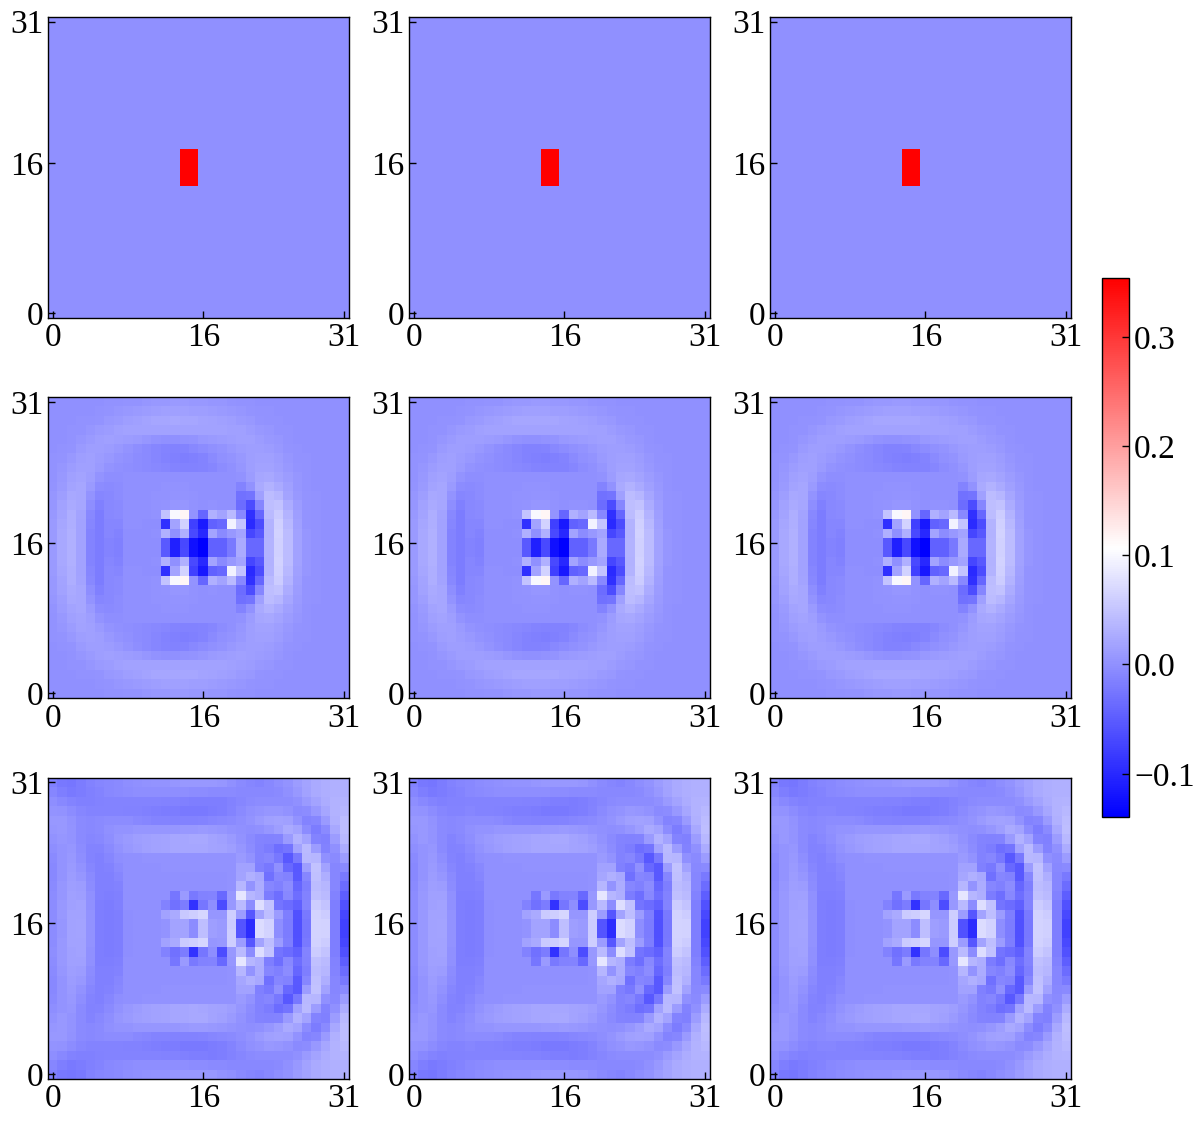

In [7]:
idx = [0, 10, 20]

u_list_tmp = u_list.copy()
u_list_tmp[:, :2**(n-2)] = (u_list[:, :2**(n-2)] / ( (v - 1.0) * np.diag(chi) + 1 )[None, :] )
psi_c_list_tmp = psi_c_list.copy()
psi_q_list_tmp = psi_q_list.copy()

vmax = None
vmin = None
for i in range(len(idx)):
    qmax = psi_q_list_tmp[int(idx[i]/dt), :2**(n-2)].real.max()
    cmax = psi_c_list_tmp[int(idx[i]/dt), :2**(n-2)].real.max()
    umax = u_list_tmp[int(idx[i]/dt_cl), :2**(n-2)].real.max()
    
    qmin = psi_q_list_tmp[int(idx[i]/dt), :2**(n-2)].real.min()
    cmin = psi_c_list_tmp[int(idx[i]/dt), :2**(n-2)].real.min()
    umin = u_list_tmp[int(idx[i]/dt_cl), :2**(n-2)].real.min()
    
    vmax_tmp = max(qmax, cmax, umax)
    vmin_tmp = min(qmin, cmin, umin)
    if vmax is None or vmax < vmax_tmp:
        vmax = vmax_tmp
    if vmin is None or vmin > vmin_tmp:
        vmin = vmin_tmp

cmap = 'bwr'
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
fig, ax = plt.subplots(len(idx), 3, figsize=(16, 14))
for i in reversed(range(len(idx))):
    x, y = np.meshgrid(np.arange(2**ny), np.arange(2**nx))
    z0 = psi_q_list_tmp[int(idx[i]/dt), :2**(n-2)].real.reshape((2**ny, 2**nx))
    ax[i, 0].imshow(z0, norm=norm, cmap=cmap, origin='lower')
    ax[i, 0].set_aspect('equal')
    ax[i, 0].set_xticks(list(range(0, 2**nx, 16)) + [2**nx - 1])
    ax[i, 0].set_yticks(list(range(0, 2**ny, 16)) + [2**ny - 1])
    
    z1 = psi_c_list_tmp[int(idx[i]/dt), :2**(n-2)].real.reshape((2**ny, 2**nx))
    ax[i, 1].imshow(z1, norm=norm, cmap=cmap, origin='lower')
    ax[i, 1].set_aspect('equal')
    ax[i, 1].set_xticks(list(range(0, 2**nx, 16)) + [2**nx - 1])
    ax[i, 1].set_yticks(list(range(0, 2**ny, 16)) + [2**ny - 1])
    
    z2 = u_list_tmp[int(idx[i]/dt_cl), :2**(n-2)].real.reshape((2**ny, 2**nx))
    ax[i, 2].imshow(z2, norm=norm, cmap=cmap, origin='lower')
    ax[i, 2].set_aspect('equal')
    ax[i, 2].set_xticks(list(range(0, 2**nx, 16)) + [2**nx - 1])
    ax[i, 2].set_yticks(list(range(0, 2**ny, 16)) + [2**ny - 1])
    print(z0.max(), z1.max(), z2.max())
pp = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                  ax=ax.ravel().tolist(), pad=0.025, shrink=0.5)